## Pose-Graph SLAM

Victoria Park Dataset (for more information such as vehicle modeling, dynamic model and measurement model see [link](https://www-personal.acfr.usyd.edu.au/nebot/victoria_park.htm).)

<img src = "https://www.researchgate.net/publication/225106837/figure/fig7/AS:668616529805327@1536422011812/FastSLAM-20-applied-to-the-Victoria-Park-Dataset.png" height = 300>

In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import g2o
import scipy
import os
import copy
import warnings
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore")

### Required Functions

In [14]:
def clamp_angle(theta):
    while theta >= np.pi:
        theta -= 2*np.pi

    while theta < -np.pi:
        theta += 2*np.pi

    return theta

def read_data_file(file_name):
    with open(file_name, "r") as f:
        raw_data = f.readlines()

    data = [ [float(x) for x in line.strip().split(',')] for line in raw_data ]

    return np.array(data)

def convert_scan(scan):
    angles = np.array(range(361))*np.pi/360 - np.pi/2
    converted_scans = (np.array([np.cos(angles), np.sin(angles)]).T * scan[:, np.newaxis])
    filter = np.bitwise_and(scan<40.0, scan>3.0)
    converted_scans = converted_scans[filter]

    return converted_scans

### ICP

In [15]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    # assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001, max_corres_distance=1.0):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points

        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # Reject pairs that have n meter distance between them
        indices = indices[distances < max_corres_distance]
        if len(indices)==0:
            break
        
        # compute the transformation between
        T,_,_ = best_fit_transform(src[:m, distances < max_corres_distance].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i


### Pose Graph

In [16]:
class PoseGraphOptimization(g2o.SparseOptimizer):
    def __init__(self):
        super().__init__()
        solver = g2o.BlockSolverSE2(g2o.LinearSolverDenseSE2())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)

    def optimize(self, max_iterations=20):
        super().initialize_optimization()
        super().optimize(max_iterations)

    def add_vertex(self, id, pose, fixed=False):
        v_se2 = g2o.VertexSE2()
        v_se2.set_id(id)
        v_se2.set_estimate(pose)
        v_se2.set_fixed(fixed)
        super().add_vertex(v_se2)

    def add_edge(self, vertices, measurement, 
            information=np.identity(3),
            robust_kernel=None):

        edge = g2o.EdgeSE2()
        for i, v in enumerate(vertices):
            if isinstance(v, int):
                v = self.vertex(v)
            edge.set_vertex(i, v)

        edge.set_measurement(measurement)
        edge.set_information(information)
        if robust_kernel is not None:
            edge.set_robust_kernel(robust_kernel)
        super().add_edge(edge)

    def get_pose(self, id):
        return self.vertex(id).estimate()


### Odometry model

In [17]:
def odom_update(u, dt, prev_init_pose, vehicle_params):
    Ve = u[0]
    alpha = clamp_angle(u[1])

    H = vehicle_params['H']
    L = vehicle_params['L']
    a = vehicle_params['a']
    b = vehicle_params['b']

    Vc = Ve/(1-np.tan(alpha)*H/L)
    
    d_x = dt*(Vc- Vc/L*np.tan(alpha)*b)
    d_y = dt*(Vc/L*np.tan(alpha)*a)
    d_theta = dt*Vc/L*np.tan(alpha)
    
    d_pose = np.array([[np.cos(d_theta), -np.sin(d_theta), d_x],
                       [np.sin(d_theta),  np.cos(d_theta), d_y],
                       [0., 0., 1.]])
    
    updated_init_pose = d_pose @ prev_init_pose
    
    return updated_init_pose

In [ ]:
robot_params = {
    "a": 3.78,
    "b": 0.50, 
    "L": 2.83,
    "H": 0.76
}

information_matrix = np.diag([0.5, 0.5, 0.1])

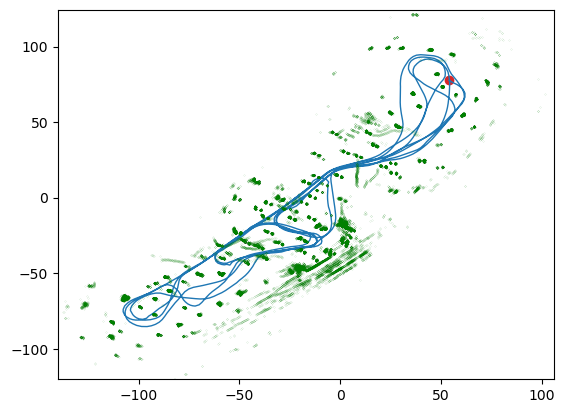

In [18]:
# readingn data
path = os.path.dirname(os.path.abspath(''))
odoms = read_data_file(os.path.join(path, "data/DRS.txt"))
gps = read_data_file(os.path.join(path, "data/GPS.txt"))
lasers = read_data_file(os.path.join(path, "data/LASER.txt"))
events = [('gps', x) for x in gps]
events.extend([('laser', x) for x in lasers])
events.extend([('odom', x) for x in odoms])
events = sorted(events, key = lambda event: event[1][0])

# Starting point
pose = np.array([[np.cos(36*np.pi/180), -np.sin(36*np.pi/180), gps[0,1]],
                            [np.sin(36*np.pi/180), np.cos(36*np.pi/180), gps[0,2]],
                            [0, 0, 1]])

# PGO
optimizer = PoseGraphOptimization()
optimizer.add_vertex(0, g2o.SE2(g2o.Isometry2d(pose)), True)
vertex_idx = 1

registered_points = []
max_x = -float('inf')
max_y = -float('inf')
min_x = float('inf')
min_y = float('inf')
last_odom_t = 0
prev_points = []
init_pose = np.eye(3,3)
fig = plt.figure()

for i, event in enumerate(events):
    t = event[1][0]
    
    # terminate
    if t > 850:
        break

    # Odometry input
    if event[0] == 'odom':
        # Initialize
        if last_odom_t == 0:
            last_odom_t = t
        else:
            u = event[1][1:]
            dt = t - last_odom_t
            if dt == 0:
                continue
            else:
                init_pose = odom_update(u, dt, init_pose, robot_params)
                last_odom_t = t

    # LiDAR input, perform scan matching
    if event[0] == 'laser' and (np.linalg.norm(init_pose[:2,2]) > 2.0 or abs(np.arctan2(init_pose[1,0], init_pose[0,0])) > 0.2):   #0.2
        if last_odom_t == 0:
            continue
        if len(prev_points)==0:
            scan = event[1][1:]
            prev_points = convert_scan(scan)
            registered_points.append(prev_points)
            continue
        
        # point to point ICP
        scan = event[1][1:]
        current_points = convert_scan(scan)
        with np.errstate(all='raise'):
            try:
                tran, distances, iter, = icp(
                    current_points, prev_points, init_pose,
                    max_iterations=20, tolerance=1e-3,
                    max_corres_distance = 0.5)
            except Exception as e:
                continue
        
        # Add new node/edge
        pose = np.matmul(pose, tran)
        optimizer.add_vertex(vertex_idx, g2o.SE2(g2o.Isometry2d(pose)))
        rk = g2o.RobustKernelDCS()
        optimizer.add_edge([vertex_idx-1, vertex_idx],
                            g2o.SE2(g2o.Isometry2d(tran)),
                            information_matrix, robust_kernel=rk)

        # For visualization/next step
        registered_points.append(current_points)
        last_odom_t = t
        prev_points = copy.deepcopy(current_points)
        init_pose = np.eye(3,3)
        
        # Loop Closure
        if vertex_idx > 10 and not vertex_idx % 10:
            new_graph = False
            poses = [optimizer.get_pose(idx).to_vector()[0:2]
                    for idx in range(vertex_idx-1)]
            
            kd = scipy.spatial.cKDTree(poses)
            x, y, _ = optimizer.get_pose(vertex_idx).to_vector()
            idxs = kd.query_ball_point(np.array([x, y]), r=10.)
            for idx in idxs:
                A = registered_points[idx]
                with np.errstate(all='ignore'):
                    try:
                        tran, distances, iter = icp(
                            A, current_points, np.eye(3,3),
                            max_iterations=40, tolerance=1e-5,
                            max_corres_distance = 0.5)
                    except Exception as e:
                        continue
                
                if np.mean(distances) < 1.1:
                    new_graph = True
                    rk = g2o.RobustKernelDCS()
                    optimizer.add_edge([vertex_idx, idx],
                                        g2o.SE2(g2o.Isometry2d(tran)),
                                        information_matrix, robust_kernel=rk)
            if new_graph:
                optimizer.optimize()
                pose = optimizer.get_pose(vertex_idx).to_isometry().matrix()

        # Visualize
        traj = []
        point_cloud = []
        draw_last = float('inf')

        for idx in range(max(0, vertex_idx-draw_last), vertex_idx):
            x = optimizer.get_pose(idx)
            r = x.to_isometry().R
            t = x.to_isometry().t
            filtered = registered_points[idx]
            filtered = filtered[np.linalg.norm(filtered, axis=1) < 80]
            point_cloud.append((r @ filtered.T + t[:, np.newaxis]).T)
            traj.append(x.to_vector()[0:2])
        
        point_cloud = np.vstack(point_cloud)
        xyreso = 0.01 # Map resolution (m)
        point_cloud = (point_cloud / xyreso).astype('int')
        point_cloud = np.unique(point_cloud, axis=0)
        point_cloud = point_cloud * xyreso

        current_max = np.max(point_cloud, axis=0)
        current_min = np.min(point_cloud, axis=0)
        max_x = max(max_x, current_max[0])
        max_y = max(max_y, current_max[1])
        min_x = min(min_x, current_min[0])
        min_y = min(min_y, current_min[1])
        traj = np.array(traj)
        
        plt.cla()
        plt.axis([min_x, max_x, min_y, max_y])
        plt.scatter(traj[-1,0], traj[-1,1], color='tab:red')
        plt.plot(traj[:, 0], traj[:, 1], color='tab:blue', linewidth=1)
        plt.plot(point_cloud[:, 0], point_cloud[:, 1], '.g', markersize=0.1)
        display(fig)
        clear_output(wait=True)

        vertex_idx += 1